# Temperature Time Series Analysis with LSTM

Global warming is the ongoing rise of the average temperature of the Earth's climate system and has been demonstrated by direct temperature measurements and by measurements of various effects of the warming - Wikipedia

So a dataset on the temperature of major cities of the world will help analyze the same. Also weather information is helpful for a lot of data science tasks like sales forecasting, logistics etc.

I illustrated forecasting implementation with three different approaches with the same data set. This is the last one in these series using deep learning model. Initially, I started with [SARIMA model](https://github.com/ali-unlu/SARIMA-time-series-analysis/blob/main/Time%20series%20analysis.ipynb). In the second model, I used [Facebook Prophet](https://github.com/ali-unlu/Time-Series-Analysis-with-Facebook-Prophet/blob/main/Time_Series_Analysis_with_Facebook_Prophet.ipynb). So, I encouraged you to check out those posts and compare the model performances. 

# 1. Data and preprocessing 

Data comes from Kaggle and it could be reached from [here](https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities). Thanks to University of Dayton, the dataset is available as separate txt files for each city. The data is available for research and non-commercial purposes only. Please refer to [this page](http://academic.udayton.edu/kissock/http/Weather/default.htm) for license.

 In this dataset, it includes daily average temperature values collected as Fahrenheit over different regions, countries, cities over the years from about 1995 to 2020.

 

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')


from sklearn.model_selection import train_test_split

import seaborn as sns

import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras


from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, LSTM, Dropout, GlobalMaxPooling1D, SimpleRNN
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping



import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv('city_temperature.csv', index_col=False)

Since the data includes many cities, I select Turkish cities. Let's see how many Turkish cities are in the data set.  

In [3]:
df= df[(df.Country =='Turkey') & (df.City == 'Istanbul')]
df.head()


,Region,Country,State,City,Month,Day,Year,AvgTemperature
1102318,Middle East,Turkey,NaN,Istanbul,1,1,1995,55.0
1102319,Middle East,Turkey,NaN,Istanbul,1,2,1995,57.1
1102320,Middle East,Turkey,NaN,Istanbul,1,3,1995,44.4
1102321,Middle East,Turkey,NaN,Istanbul,1,4,1995,47.6
1102322,Middle East,Turkey,NaN,Istanbul,1,5,1995,44.1


### Missing values
During the EDA, some values in temperature are missing (-99). Let's first check out how many variables are missing. We noticed that there are 30 values are missing and we replace then with ffill function. 

In [4]:
"""-99 is put in place of missing values. 
We will have to forward fill with the last non missing value before -99
"""
df["AvgTemperature"] = np.where(df["AvgTemperature"] == -99, np.nan, df["AvgTemperature"])
df.isnull().sum()



Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature      30
dtype: int64

In [5]:
df["AvgTemperature"] = df["AvgTemperature"].ffill()
df.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
dtype: int64

### Celsius Conversion 
Finally, we can convert AvgTemperature from Fahrenhei to Celsius

Formula (°F − 32) × 5/9.

In [6]:
df['AvgTemperature'] = (df['AvgTemperature']  -32) * 5/9 


### Average temperature of Istanbul

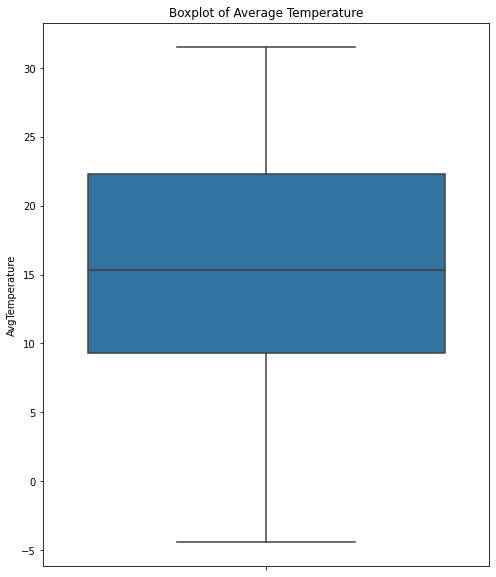

In [11]:
plt.figure(figsize = (8,10))
sns.boxplot(data = df,y = 'AvgTemperature')
_=plt.title("Boxplot of Average Temperature")

So, basically the average temperature for Istanbul is around 15 C changing seasonally. 

### Date process

The Year, Month and Day comes as a separate column, I merged them and create a new date variable. 

In [12]:
def make_date(row):
    return datetime(year = row['Year'], month = row['Month'], day = row['Day'])


df['date'] = df.apply(make_date,axis=1)
df.set_index(df.date,inplace=True)

Let's just look at the temperature change in Istanbul. 

<AxesSubplot:xlabel='date'>

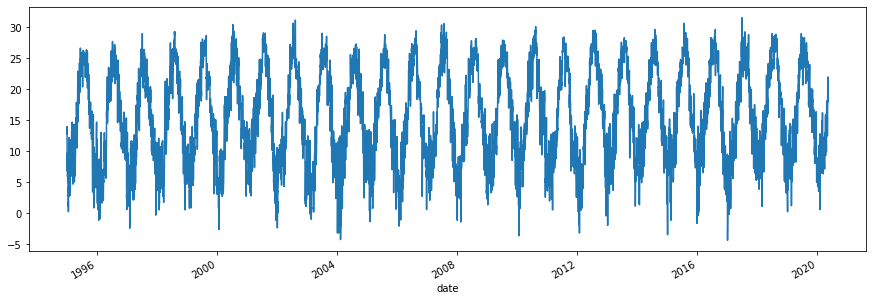

In [13]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df[df['City'] == 'Istanbul']['AvgTemperature'].plot()

In [14]:
df2= df[['date', 'AvgTemperature']]
df2.head()

,date,AvgTemperature
date,,
1995-01-01,1995-01-01,12.777778
1995-01-02,1995-01-02,13.944444
1995-01-03,1995-01-03,6.888889
1995-01-04,1995-01-04,8.666667
1995-01-05,1995-01-05,6.722222


We do not need all columns, so I only select temperature and date columns from the data set. I also make data column as the index. Here is the head and tail of the data set. 

## Subsetting dates
As usual, it's a good idea for us to generate a run-sequence plot before modeling the data. This way we can get a feel for what we're working with. We'll go ahead and define two utility functions that let us extract and plot the last  𝑛  days of data.

Here, I show the last 120 days of temperature in Istanbul. Since it started in January, the temperature increased contitniously. 

In [15]:
def get_n_last_days(df, n_days):
    """
    Extract last n_days 
    """
    
    return df['AvgTemperature'][- n_days:] 

def plot_n_last_days(df, n_days):
    """
    Plot last n_days
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df,  n_days), 'k-') # call the previous function
    plt.title('Air Quality Time Series - {} days'
              .format( n_days))
    plt.xlabel('Recorded daily')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

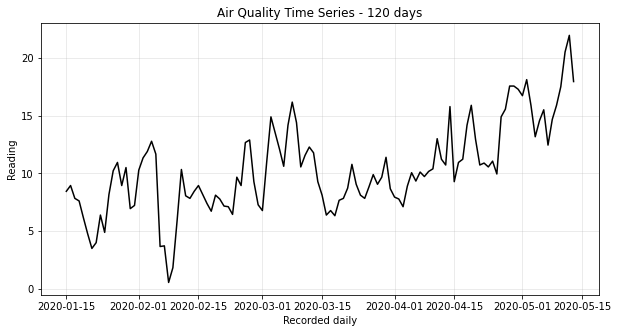

In [16]:
plot_n_last_days(df2, 120)

# Keras data structure

Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape **(n_samples, time_steps, n_features)**. Since we'll be using only the series' history to predict its future, we'll only have 1 feature. Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.

To this end, we define utility functions that allow us to extract the formatted data. The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.

Since our model will perform better with multiple training samples, we draw many slices from the entire training sequence, starting at different points in time. The gap between starting points of these slices is controlled by the **sample_gap** parameter.

In [99]:
def get_keras_format_series(series): # if you want to add feature, you can mention here
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1) 

def get_train_test_data(df, series_days, input_days, 
                        test_days, sample_gap=3): 
    """
    Utility processing function that splits a daily time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_day (int): length of sequence input to network 
    test_days (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_days] # training data is remaining days until amount of test_days
    test = forecast_series[-test_days:] # test data is the remaining test_days

    train_X, train_y = [], []

    # range 0 through # of train samples - input_daily by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_days, sample_gap): # 
        train_X.append(train[i:i+input_days]) # each training sample is of length input daily
        train_y.append(train[i+input_days]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_days] 
    test_y = test[input_days:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

With the get_train_test_data utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 720 days of the temmperature, and will train a model that takes in 7 time steps (weekly) in order to predict the next time step. We use the last day of data for visually testing the model.

In [159]:
series_days = 1460 # how many days we pull from data

input_days = 7 # 
test_days = 14 # 

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df2,  series_days, 
                         input_days, test_days))

In [160]:
train_y.shape

(480,)

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each. 

In [161]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (480, 7, 1)
Training output shape: (480,)
Test input shape: (7,)
Test output shape: (7,)


# Simple RNN Model

And now we're ready to train! Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras. Take some time to understand what the keras syntax accomplishes at each step and how it relates to what we've learned about RNNs so far.

In [162]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

__Model fit:__ Now let's use this function to fit a very simple baseline model.

In [163]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

**Prediction:** Now, we need to extract multi-step predictions from this model, as it was trained to predict only one future time step. For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model. We stop once we've generated all the time step predictions we need.

This prediction method and a utility function for plotting its output against the ground truth are defined below. Take some time time to familiarize yourself with the prediction method.


In [164]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_days)  #predict range is going to be from end of X_init to length of test_days
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

**Plot :** Ok, we've finally arrived at the time to see how our baseline model does. We can simply run the predict_and_plot function on the extracted test data as below, and inspect the resulting plot.

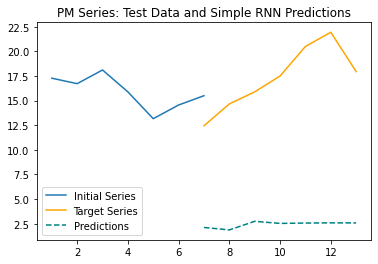

In [165]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

It looks like our model is badly underfit and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly.
We can improve by making the model more expressive, increasing cell_units. We can also pass over the training data many more times, increasing epochs, giving the model more opportunity to learn the patterns in the data. We'll try that below, it takes a longer time now since our training is more extensive.
Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get results that we're happy with.

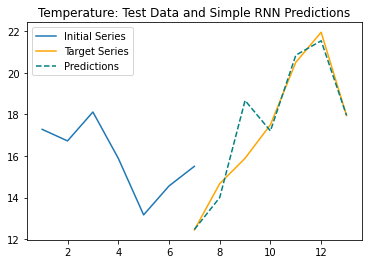

In [174]:
model = fit_SimpleRNN(train_X, train_y, cell_units=50, epochs=4100) # 
predict_and_plot(test_X_init, test_y, model,
                 'Temperature: Test Data and Simple RNN Predictions')

We can definitely get better results than before. Note that the model has the capacity to forecast an upward trend based on the trough pattern that occured recently (the input sequence). It seems that our model is better to predict a week long temperature. 

**Model Summary:** Once we've created a model object, we can also get information about its structure and number of parameters by using the summary function. This is a useful way to measure the complexity of the model and get a feel for how long it may take to train.

In [175]:
model.summary()

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_80 (SimpleRNN)    (None, 50)                2600      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


Note that even for this relatively simple model, we already have almost a thousand parameters to train. A larger number of cell units would increase the number of parameters - this is why the training process can become so time consuming.

# LSTM Model

In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far. Our first step will be to write a new function for fitting an LSTM with keras - notice that it's almost the same as our simple RNN function, with LSTM substitued for SimpleRNN (this is a nice display of how flexible keras is).

In [196]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))


    
    # add an output layer to make final predictions
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

With our new LSTM training function and all of our previously defined utility functions, adapting our code for LSTM forecasting will be fairly simple. We can extract the data as we did before, call the fit_LSTM function to build a model, and run the same predict_and_plot code.

One of the key benefits of LSTMs over simple RNNs is that they are better equipped to handle long input sequences and long-term dependencies. To see this evidence of this, we'll set input_days to 7 and test_days to 14 and see how our model predictions turn out with LSTM. I will use the same parameters to see whether the results differ. 

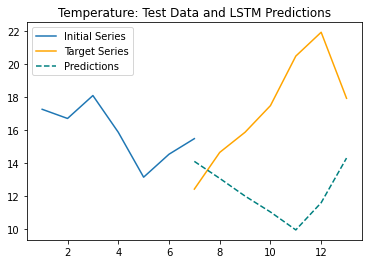

In [197]:
series_days = 1460 # 4 years
input_days = 7
test_days = 14

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df2, series_days, 
                         input_days, test_days))

model = fit_LSTM(train_X, train_y, cell_units=50,  epochs=4100) 

predict_and_plot(test_X_init, test_y, model, 
                 'Temperature: Test Data and LSTM Predictions')

In [198]:
model.summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


**Model Tuning:** Here I included here couple of more layers. First, I added one more LSTM layer and then two output layers. Moreoever, I also reduced the batch size. Depending on your computer power, you can play with cell sizes and epochs. 

In [199]:
def fit_LSTM(train_X, train_y, cell_units, cell_units_l2,  epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1),return_sequences= True))
    model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1), return_sequences= True))


    
    # add an output layer to make final predictions
    model.add(GlobalMaxPooling1D())# yeni
    model.add(Dropout(0.25))# yeni
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=20, verbose=0)
    
    return model

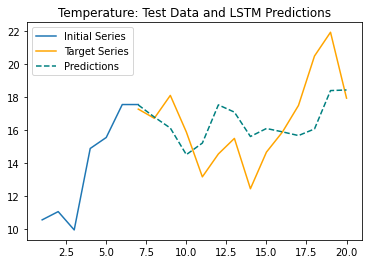

In [200]:
series_days = 8000 # 
input_days = 7
test_days = 21

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df2, series_days, 
                         input_days, test_days))

model = fit_LSTM(train_X, train_y, cell_units=80,cell_units_l2=80,  epochs=8000) 

predict_and_plot(test_X_init, test_y, model, 
                 'Temperature: Test Data and LSTM Predictions')

In our prediction plot we can start to see how LSTMs can be more expressive than simple RNNs - instead of just extrapolating a simple trend like our previous RNN models did, this LSTM model can effectively anticipate inflection points.
You should also notice that our model starts to struggle toward the end of the predicted sequence, becoming more conservative in its predictions. To improve the quality of forecasts over many time steps, we'd likely need to use more data and more sophisticated LSTM model structures.
Take a look at the model summary and compare it with the summary for our simple RNN from example 1. You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.

In [201]:
model.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 7, 80)             26240     
_________________________________________________________________
lstm_29 (LSTM)               (None, 7, 80)             51520     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 80)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 81        
Total params: 77,841
Trainable params: 77,841
Non-trainable params: 0
_________________________________________________________________


### Further Exploration

The simple models we've worked with are only the tip of the iceberg for deep learning. We've been time-limited for this exercise, and typical deep learning models involve much longer training times than what we're able to do in this notebook. You can easily implement the model till the last model, it is pretty straight forward but for the last model, you need time and a strong computer. 

Here are several __suggestions__ for how you could explore these ideas further, leveraging the code we've implemented today:
- Try using longer chunks of the series we've looked at in this notebook for modeling (set series_days larger than 4 years), or modeling other series in the dataset.
- When training with more data, try increasing cell_units and running more training epochs.
- Try using longer input sequences with LSTM, and predicting a wider range of test days.

# Summary 

**In this post we have covered:**
- How recurrent neural networks can be applied to sequence forecasting problems  
- How simple RNNs and LSTMs can be built and trained using the python library keras  
- The importance of tuning network parameters, and an introductory strategy for doing so  